In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/QPC_double_dot/"


In [3]:
ll=100
data_route = "../../data/exact_diag_new/L={}/".format(ll)

J=1


# Checking correct initial condition

Here we make sure that the occupation of the qubit 0 state is at roughly the same  for all different velocities. We achieve this by tweaking the initial conditions at at $\Omega=0$

In [4]:
# file_list = get_file_names_on(["om0.1","bw2.0","t0.1", "dd0fixed"], data_route)
file_list = get_file_names_on(["om0.3","Del7.0","t0.3", "k1.0996","alpha_bond0.785"], data_route)
file_list2 = get_file_names_on(["om0.3","Del7.0","t0.01", "k1.0996", "alpha_bond0.785"], data_route)
file_list3 = get_file_names_on(["om0.3","Del7.0","t0.1", "k1.0996", "alpha_bond0.785"], data_route)

# k1.4137

file_list = file_list+ file_list2+file_list3
file_list

['exact_L100_J1.0_t0.3_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.972_beta0.028_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.01_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.923_beta0.077_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.1_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.556_beta0.444_phi0.0_alpha_bond0.785_qinitfixed.h5']

Text(0.5, 0, 'Time')

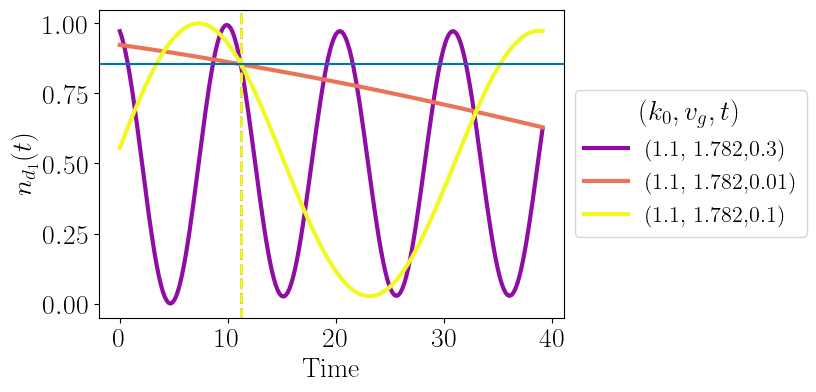

In [5]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name)  
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["K0"])
    tau_to_bond = (param_dict["bond_index"]-param_dict["X0"])/vg
    
    lab = "("+str(round(param_dict["K0"],3)) + ", " + str(round(vg,3))+ "," +str(param_dict["t"]) + ")" 
    
    plt.plot(times, d0_density, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.axhline(np.cos(0.785/2)**2)
plt.legend(title=r"$(k_0, v_g, t)$",loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



# Generating Analysis dataframe

Here we put all the processed and raw data in a dataframe for convenient reading abd analysis

In [6]:
def get_free_orbit(ρ0, cosθ0, ϕ0 ,time_range,ti):
    # calculate the free orbit of a qubit based ond the given einitial conditions
    rho_free_list = [ρ0]
    theta_free_list = [np.arccos(np.real(cosθ0))]
    phi_free_list = [ϕ0]
    for i in range(1,len(time_range)):
        # rotate up to time tau
        τ = time_range[i] 
        rho_tau = rotate_rho(rho_free_list[0], τ, ti , ϕ0)
        # get the angles at that tau
        Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
        
        rho_free_list.append(rho_tau)
        theta_free_list.append(np.arccos(Cos_theta_p))
        phi_free_list.append(np.arcsin(Sin_phi_p))

    return rho_free_list, theta_free_list, phi_free_list

def get_euclidean_distance(costheta, sinphi, theta_free_list, phi_free_list):
    # gets the euclidean distance between the free orbit and the coupled one 

    # Now plot the numerical coupled case
    dd_theta = np.real(np.arccos(costheta))
    dd_phi = np.real(np.arcsin(sinphi))
    
    # calculate the equclidean distance between each point of the decoupled and interacting orbits
    x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
    y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
    z_free = np.cos(theta_free_list)
    
    x_ = np.sin(dd_theta)*np.cos(dd_phi)
    y_ = np.sin(dd_theta)*sinphi
    z_ = np.asarray(costheta)
    
    e_distance = np.real(np.sqrt((x_free-x_)**2 + (y_free-y_)**2 + (z_free-z_)**2))
    e_distance = e_distance[1:] # the first one is pruged because of inacuracies

    return e_distance
    

In [7]:
file_list = get_file_names_on([], data_route)


In [9]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []
data_dict["backaction_time"] = []
data_dict["backaction_max"] = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    costheta_list, sinphi_list = get_bloch_angles_time(qubit_rho)

    # get the backaction
    rho_free_list, theta_free_list, phi_free_list = get_free_orbit(qubit_rho[0], costheta_list[0], param_dict["phi"],
                                                                   times,param_dict["phi"])
    
    backaction = get_euclidean_distance(costheta_list, sinphi_list, theta_free_list, phi_free_list)

    # save raw data 
    data_dict["times"].append(list(times.astype(np.float32)))
    data_dict["occupations"].append(occupations.astype(np.float32))
    data_dict["d0_density"].append(d0_density.astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append(list((entropy/np.log(2)).astype(np.float32)))
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(costheta_list)
    data_dict["sin_phi"].append(sinphi_list)
    data_dict["backaction_time"].append(backaction.astype(np.float32))
    data_dict["backaction_max"].append(backaction[-1].astype(np.float32))

data_df = pd.DataFrame.from_dict(data_dict)

# data_df.to_csv("../../data/exp_pro/exact_diag_L={}.csv".format(ll))

not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possibl

choose our params we want to look at

In [10]:
Om_ = 0.3 
X0_ = 30

af = data_df["alfabond"].sort_values().unique()[2]
print(np.cos(af/2)**2)
data_df["alfabond"].sort_values().unique()
K0_unique = data_df["K0"].unique()

0.8535533905932737


# Backaction

we calculate the change backaction from the euclidean distance between the Bloch sphere orbits **I should plug this in the function above so its part of the data processing part**

In [11]:
print(np.cos(af/2)**2)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_)  & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)
back_df = data_df[cond_].sort_values(by="K0")


0.8535533905932737


In [12]:
B_df = back_df.pivot(index='K0', columns='t', values='backaction_max')
B_df

t,0.0001,0.0010,0.0100,0.0200,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,...,0.3000,0.4000,0.5000,0.7000,0.8000,0.9000,1.0000,2.0000,3.0000,5.0000
K0,,,,,,,,,,,,,,,,,,,,,
0.157080,0.656257,0.606154,1.471843,1.888292,0.863076,1.038374,1.922067,1.499319,0.443612,1.589648,...,1.905470,1.948603,1.623386,0.277828,0.756807,1.466302,1.903877,1.104752,1.303294,0.288867
0.314159,0.726479,0.693634,1.380651,1.810621,1.047327,1.071747,1.868086,1.457865,0.594560,1.616946,...,1.891478,1.942453,1.627062,0.356796,0.766801,1.450726,1.890940,1.114378,1.298377,0.285256
0.471239,0.602722,0.581572,1.268135,1.870126,1.524183,0.707757,1.315228,1.884911,1.508111,0.624552,...,1.756667,1.226967,1.356587,0.811403,1.932023,0.268776,1.972942,0.500813,1.844800,1.566014
0.628319,0.488659,0.476970,1.064001,1.755705,1.904444,1.446540,0.674819,0.901977,1.643323,1.920870,...,1.685438,1.942828,1.960500,1.315094,0.740758,0.220077,0.682800,1.271805,1.731856,1.966698
0.785398,0.404216,0.398080,0.924490,1.600449,1.936477,1.831021,1.317058,0.604005,0.695973,1.407456,...,1.559365,1.530753,0.959049,0.254975,1.971398,0.701897,1.691909,1.781481,0.134355,1.827059
0.942478,0.343100,0.340360,0.830122,1.474101,1.878871,1.951622,1.677741,1.117863,0.465736,0.666467,...,0.811495,1.971967,0.826869,1.874356,0.219202,1.785575,1.518618,1.970593,0.992114,1.888655
1.099557,0.299571,0.298983,0.764526,1.379098,1.809422,1.974730,1.847501,1.449266,0.854643,0.326112,...,1.460866,0.352449,1.351028,1.512821,0.254185,1.259901,1.977877,0.503814,1.850032,1.585891
1.178097,0.283237,0.283401,0.739748,1.341902,1.777800,1.971739,1.893893,1.556284,1.014108,0.407378,...,1.881229,1.183246,0.327727,1.901700,1.886646,1.164050,0.182972,0.005185,0.012859,0.031515
1.256637,0.270136,0.270899,0.720810,1.313203,1.752013,1.965551,1.922951,1.630360,1.131469,0.523912,...,1.978909,1.731083,1.044895,1.005008,1.712728,1.990755,1.751898,1.658487,0.221992,1.511193


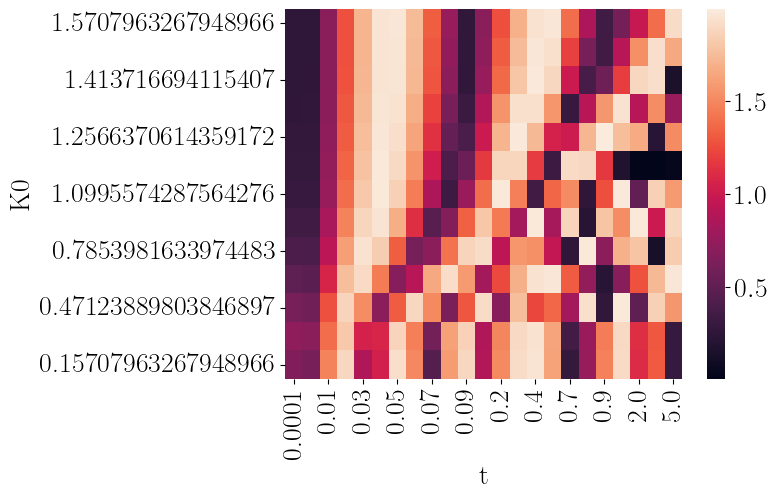

In [13]:
fig, ax = plt.subplots(1,1)
sns.heatmap(B_df)
ax.invert_yaxis()

## Individual cases

In [14]:
ti = 0.09
cond_2 = (back_df["K0"]==K0_unique[0]) &  (back_df["t"]==ti)
curr_df = back_df[cond_2]

In [15]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
time_range = curr_df["times"].item()
#bindex = curr_df["bond_index"].item()
ϕ0 = curr_df["phi"].item()
rhot = curr_df["qubit_rho"].item()
cosθ0 = costheta[0]


In [16]:
rho_free_list, theta_free_list, phi_free_list = get_free_orbit(rhot[0], cosθ0, ϕ0,time_range,ti)


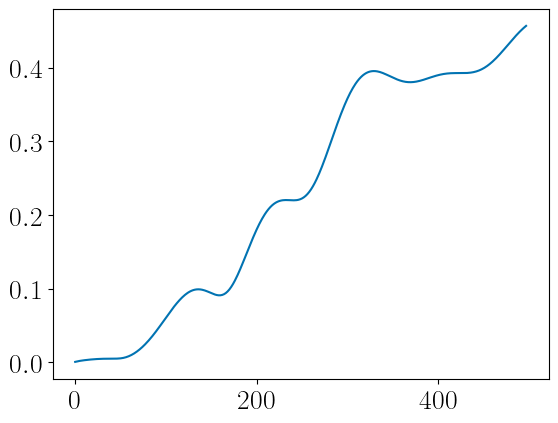

In [17]:
rho_free_list, theta_free_list, phi_free_list = get_free_orbit(rhot[0], cosθ0, ϕ0,time_range,ti)
backaction = get_euclidean_distance(costheta, sinphi, theta_free_list, phi_free_list)

plt.plot(backaction)

### PLotting the bloch sphere

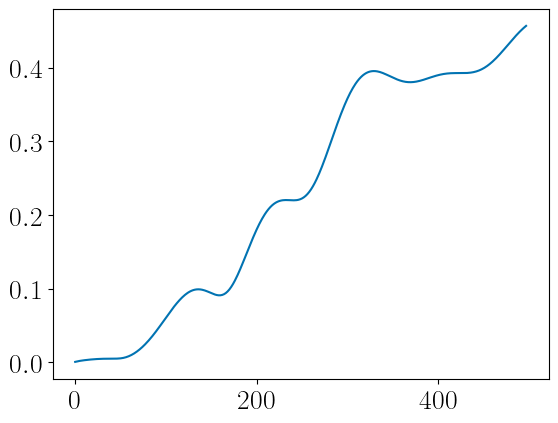

In [18]:
# Now plot the numerical coupled case
dd_theta = np.real(np.arccos(costheta))
dd_phi = np.real(np.arcsin(sinphi))

# calculate the equclidean distance between each point of the decoupled and interacting orbits
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*sinphi
z_ = np.asarray(costheta)


e_distance = np.real(np.sqrt((x_free-x_)**2 + (y_free-y_)**2 + (z_free-z_)**2))
e_distance = e_distance[1:]
plt.plot(e_distance)

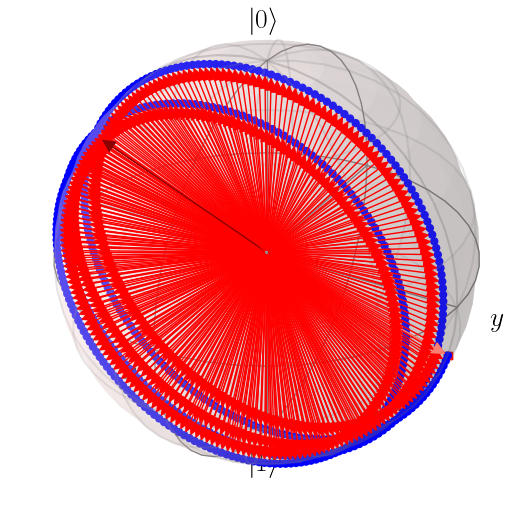

In [19]:

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color
free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]] # first point for different color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])
bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.add_points(free_first)

#bs.view = [-20, 30]  

bs.show()

# Entropy Phase diagram

In [20]:

print(np.cos(af/2)**2)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_)  & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot(index='K0', columns='t', values='Max_entropy')
S_df

0.8535533905932737


t,0.0001,0.0010,0.0100,0.0200,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,...,0.3000,0.4000,0.5000,0.7000,0.8000,0.9000,1.0000,2.0000,3.0000,5.0000
K0,,,,,,,,,,,,,,,,,,,,,
0.157080,0.397372,0.384183,0.287111,0.293506,0.338504,0.322504,0.265735,0.238783,0.244579,0.258241,...,0.164017,0.143839,0.137716,0.116074,0.085141,0.133921,0.078964,0.007606,0.002102,0.000760
0.314159,0.402662,0.411204,0.503787,0.538995,0.527189,0.521525,0.491391,0.451457,0.411788,0.376149,...,0.203696,0.184032,0.164681,0.169876,0.135107,0.136801,0.133471,0.007668,0.002001,0.000719
0.471239,0.309272,0.313448,0.358923,0.397346,0.415030,0.420994,0.421851,0.419125,0.414626,0.408047,...,0.171824,0.158083,0.147135,0.124902,0.121770,0.110621,0.104378,0.006880,0.001878,0.000662
0.628319,0.233867,0.235436,0.252477,0.271226,0.286672,0.297947,0.305649,0.310815,0.314348,0.316801,...,0.152630,0.125774,0.115973,0.101219,0.095341,0.089756,0.084894,0.006191,0.001811,0.000657
0.785398,0.185104,0.185808,0.193358,0.202168,0.210569,0.217972,0.224129,0.229086,0.233077,0.236418,...,0.209323,0.128582,0.096317,0.084120,0.079781,0.075964,0.072591,0.005838,0.001783,0.000650
0.942478,0.154008,0.154389,0.158408,0.163117,0.167798,0.172209,0.176179,0.179618,0.182514,0.184920,...,0.221081,0.186037,0.118629,0.073163,0.070060,0.067749,0.065987,0.005607,0.001904,0.000698
1.099557,0.134203,0.134445,0.136950,0.139846,0.142740,0.145525,0.148108,0.150426,0.152442,0.154144,...,0.175991,0.187637,0.174001,0.080741,0.066310,0.064982,0.065176,0.005033,0.001936,0.000770
1.178097,0.127307,0.127510,0.129597,0.131987,0.134368,0.136662,0.138802,0.140735,0.142429,0.143867,...,0.157609,0.168430,0.175879,0.103609,0.073226,0.066096,0.067480,0.005212,0.002056,0.000703
1.256637,0.121996,0.122172,0.123971,0.126012,0.128035,0.129981,0.131798,0.133444,0.134890,0.136120,...,0.143940,0.151515,0.162982,0.133923,0.093441,0.073527,0.072435,0.004905,0.001878,0.000771


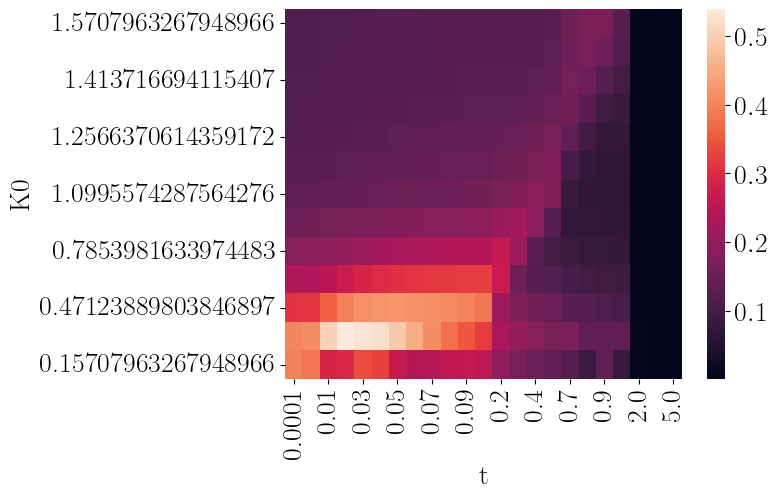

In [21]:
fig, ax = plt.subplots(1,1)
sns.heatmap(S_df)
ax.invert_yaxis()

In [22]:
print(data_df["L_qpc"].unique())
LL = data_df["L_qpc"].unique()[0]
J = data_df["J"].unique()[0]


[100]


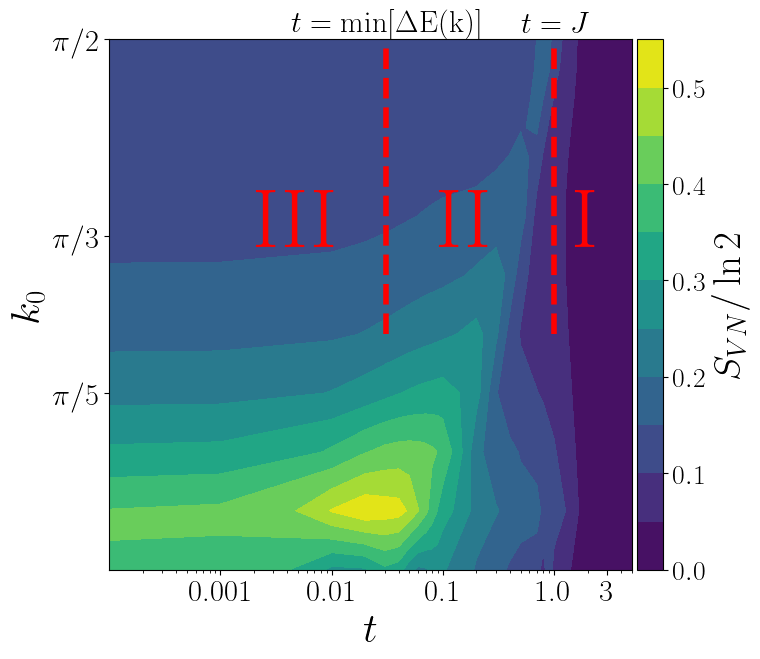

In [23]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(t_array, vg_array, S_df.values,levels=10)

plt.xscale('log')

# Add anotate the regions
y_tick = np.pi/2 -0.04
ax.annotate(
    r'$t=\rm{min}[ \Delta E(k)]$', 
    xy=(np.pi/(LL+1), y_tick), 
    xytext=(np.pi/(LL+1), y_tick + 0.06), fontsize=22,ha='center')
ax.annotate(
    r'$t=J$', 
    xy=(J, y_tick), 
    xytext=(J, y_tick + 0.06), fontsize=22,ha='center')

# Add the labels for each region
ax.annotate('II', xy=(0.1+np.pi/50, 0.65*np.pi/2), 
            xytext=(0.1+np.pi/50, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('III', xy=(0.005, 0.65*np.pi/2), 
            xytext=(0.005, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('I', xy=(2.0, 0.65*np.pi/2), 
            xytext=(2.0, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.vlines([np.pi/(LL+1), J], ymin=0.5*np.pi/2, ymax=np.pi/2, color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line

ax.set_xticks( [0.001, 0.01,0.1,1.0,3], [0.001, 0.01,0.1,1.0,3] ,fontsize=22)
ax.set_yticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}/\ln{2}$', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

# plt.savefig(fig_route+"entropy_phase_diagram_new.pdf",transparent=True)

# Entropy Production

I need to compare this directly to perturbation theory

In [33]:
t_ = 0.05

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==X0_)  & (data_df["alfabond"]==af)
curr_df = data_df[cond_].sort_values(by="K0")


## As a function of time for fixed $t$

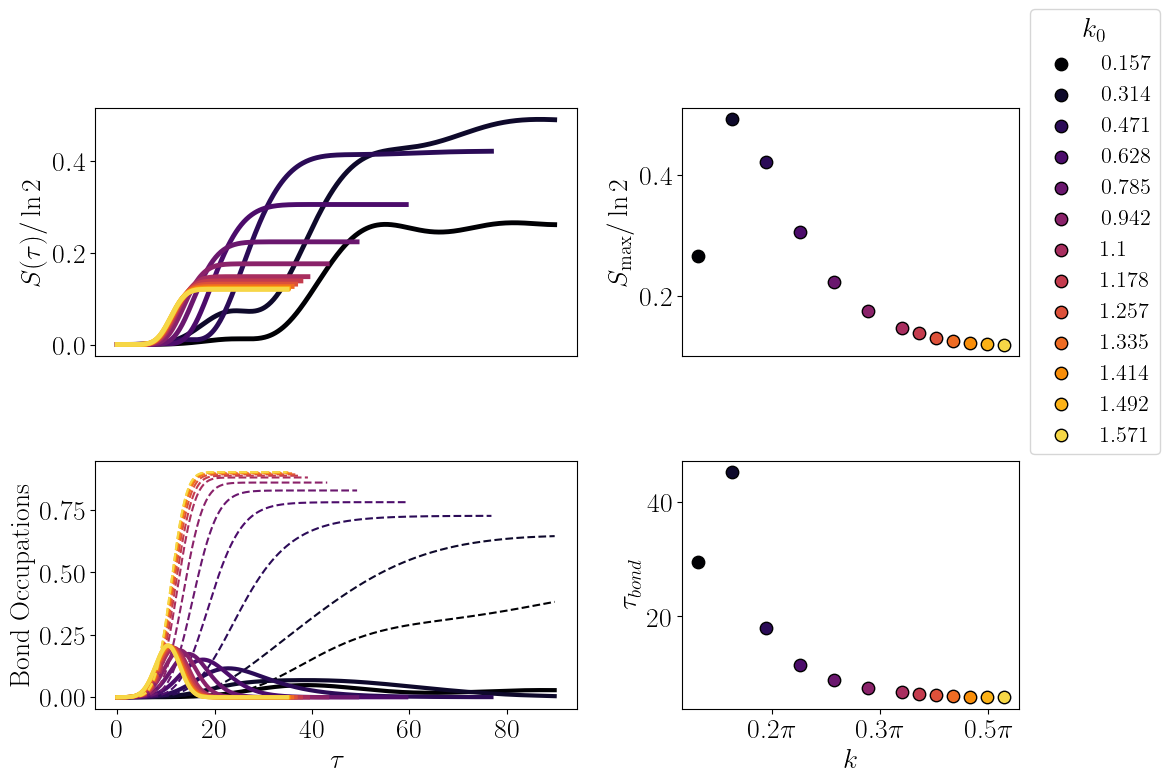

In [34]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,8))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)


# Set up labels and legends
plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}/\ln{2}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

## Maximum entropy as a function of $t$ for fixed $k_0$

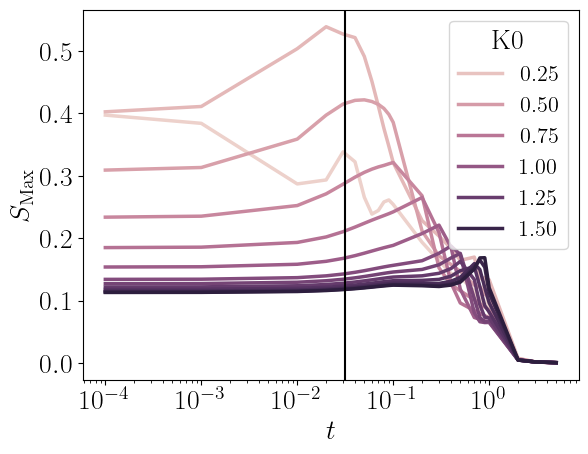

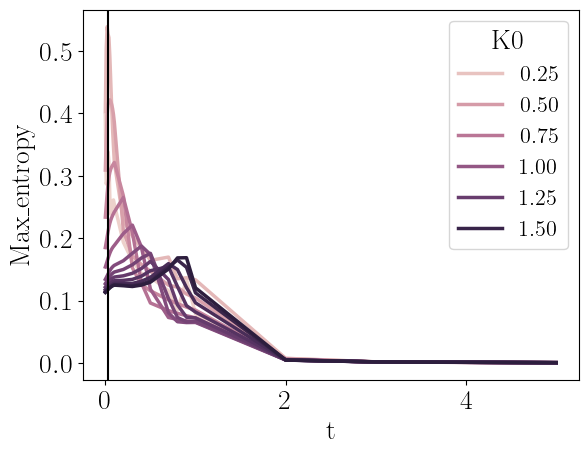

In [35]:

cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)
curr_df = data_df[cond_]

plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.axvline(np.pi/(ll+1), c= "black")
plt.xscale('log')
plt.ylabel(r"$S_{\rm{Max}}$")
plt.xlabel(r"$t$")


plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.axvline(np.pi/(ll+1), c= "black")


## Maximum entropy as a function of occupation at bond when hit for fixed $k_0$ and $t$

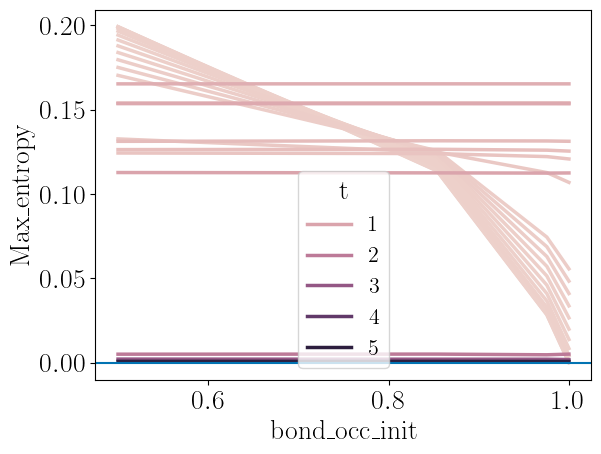

In [36]:
cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==X0_) & (data_df["K0"]==np.sort(data_df["K0"].unique())[-2]) 
curr_df = data_df[cond_].copy()
curr_df["bond_occ_init"] = np.cos(curr_df["alfabond"]*0.5)**2
plt.figure()
sns.lineplot(data=curr_df, x="bond_occ_init", y="Max_entropy", hue="t", linewidth=2.5)
plt.axhline(0)


# Single cases

In [40]:
k0_list = np.sort(data_df["K0"].unique())
print(k0_list)
k0_ = k0_list[0]
print(Om_, t_, k0_,X0_)

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)  & (data_df["X0"]==X0_) &  (data_df["alfabond"]==af)
curr_df = data_df[cond_]


[0.15707963 0.31415927 0.4712389  0.62831853 0.78539816 0.9424778
 1.09955743 1.17809725 1.25663706 1.33517688 1.41371669 1.49225651
 1.57079633]
0.3 0.05 0.15707963267948966 30


## Wavefunction

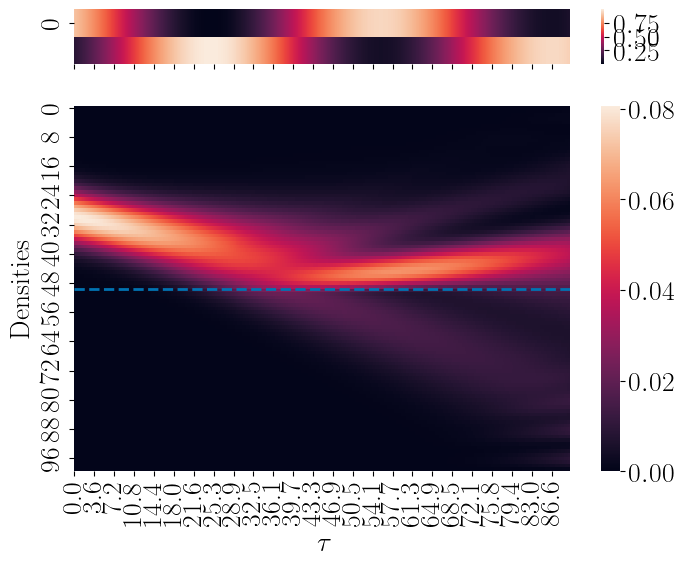

In [42]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


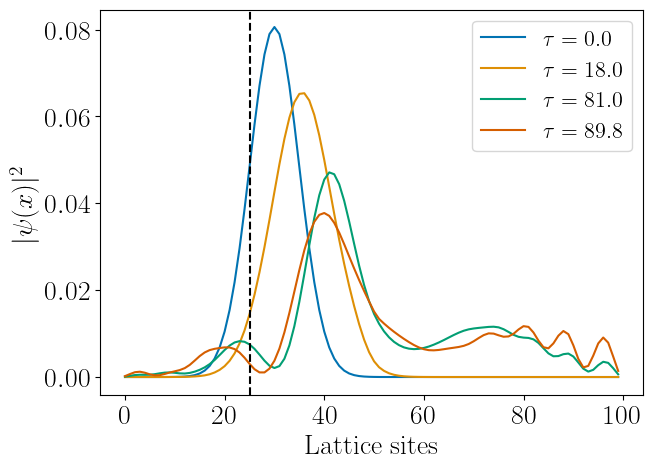

In [43]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bheight))

plt.plot(traj_matrix[:,0], label=r"$\tau={:.3}$".format(time_range[0]))
plt.plot(traj_matrix[:,100], label=r"$\tau={:.3}$".format(time_range[100]))
plt.plot(traj_matrix[:,-50], label=r"$\tau={:.3}$".format(time_range[-50]))
plt.plot(traj_matrix[:,-1], label=r"$\tau={:.3}$".format(time_range[-1]))
plt.axvline(25, c="black", linestyle="dashed")
plt.xlabel("Lattice sites")
plt.ylabel(r"$|\psi (x)|^2$")
plt.legend()

## Bloch Sphere

In [44]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
time_range = curr_df["times"].item()
bindex = curr_df["bond_index"].item()
ϕ0 = curr_df["phi"].item()
rhot = curr_df["qubit_rho"].item()

τbond = X0_ - bindex/(2*J*np.sin(k0_))
cosθ0 = costheta[0]

data_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi', 'backaction_time', 'backaction_max'],
      dtype='object')

In [45]:
rho_free_list = [rhot[0]]
theta_free_list = [np.arccos(np.real(cosθ0))]
phi_free_list = [ϕ0]

# calculate the free qubit bloch angles as a funciton of time
# by using the rotaiton matrix of the free dynamics

for i in range(1,len(time_range)):
    # rotate up to time tau
    τ = time_range[i] 
    rho_tau = rotate_rho(rho_free_list[0], τ, t_ , ϕ0)
    # get the angles at that tau
    Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
    
    rho_free_list.append(rho_tau)
    theta_free_list.append(np.arccos(Cos_theta_p))
    phi_free_list.append(np.arcsin(Sin_phi_p))


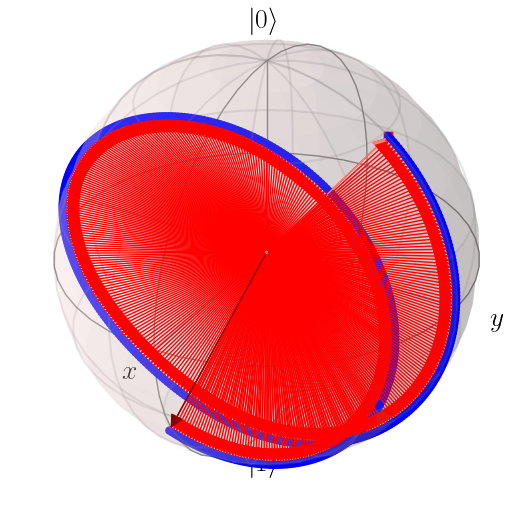

In [46]:
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*sinphi
z_ = np.asarray(costheta)

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

# writting out free case solution in spherical coordinates
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)

free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]] # first point for different color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])
bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.add_points(free_first)

#bs.view = [-20, 30]  

bs.show()

Text(0.5, 0, '$\\tau$')

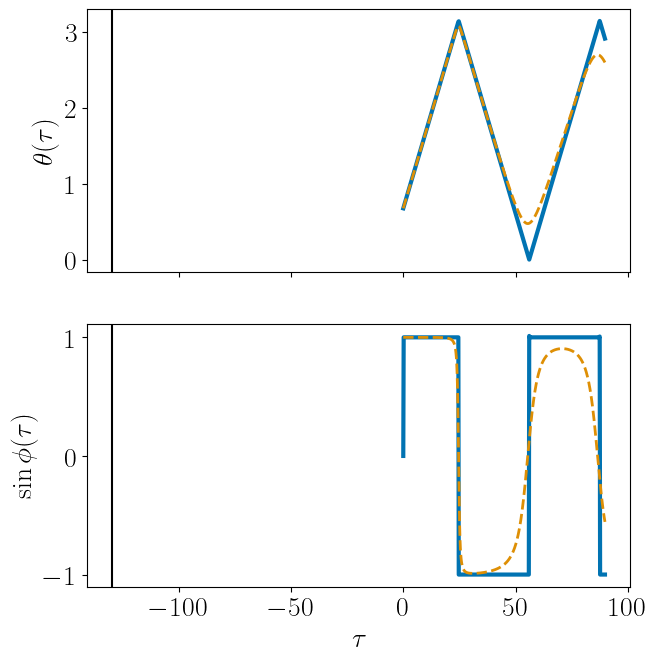

In [47]:
fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(time_range, np.real(theta_free_list), linewidth=3)
ax[0].plot(time_range, np.real(dd_theta), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τbond, c="black")

ax[1].plot(time_range, np.real(np.sin(phi_free_list)), linewidth=3 )
ax[1].plot(time_range, np.real(sinphi),linewidth=2.0, linestyle="dashed")
ax[1].axvline(τbond,c="black")

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\sin\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")

# Comparing with Qutip (smaller system)

In [48]:
print(K0_unique)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==11)
curr_df = data_df[cond_].sort_values(by="K0")


[0.15707963 0.31415927 0.4712389  0.62831853 0.78539816 0.9424778
 1.09955743 1.17809725 1.25663706 1.33517688 1.41371669 1.49225651
 1.57079633]


In [33]:
drold = '../../data/sims/L=21/'
file_listold = get_file_names_on(["om{}_".format(Om_), "k1.5708","t{}".format(t_),"bw2.0"], drold)
file_name = file_listold[0]
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(drold,file_name)
τb  = param_dict["bond_index"]/(2 * J * np.sin(param_dict["k0"]))

file_listold

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5']

In [34]:

xvals = curr_df[curr_df["K0"]== K0_unique[-1]]["times"].item()
yvals = curr_df[curr_df["K0"]== K0_unique[-1]]["entropy"].item()

times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))

plt.plot(times_coarse, VN_entropy/np.log(2))
plt.plot(xvals, curr_df[curr_df["K0"]==K0_unique[-1]]["entropy"].item() , linestyle="dashed")

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
data_full_df = pd.read_csv('../../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()
data_full_df["Max_entropy_norm"] = data_full_df["max_VN_entropy"]/np.log(2)

In [ ]:
hop_list = [0.01, 0.1, 0.3, 0.4,0.5,1.0]

In [ ]:
cond_old =  (data_full_df["x_spread"] == 2.0) & (data_full_df["Omega"] == Om_) & (data_full_df["t"].isin(hop_list))
cond_ = (data_df["Omega"]==Om_) & (data_df["K0"]>0.1)  & (data_df["qubit_init"]=="fixed") & (data_df["t"].isin(hop_list))
print(data_full_df[cond_old]["t"].unique())
print(data_df[cond_]["t"].unique())

In [ ]:
# odl data
sns.scatterplot(data= data_full_df[cond_old], x = "k0", y="Max_entropy_norm", s = 90, marker="X", hue="t")
sns.scatterplot(data= data_df[cond_], x = "K0", y="Max_entropy", s = 70, marker="o",hue="t")

plt.legend(
    title=r"$t$",
    bbox_to_anchor=(1.05, 1),  # position legend outside to the right
    loc='upper left',
    borderaxespad=0
)